In [1]:
import pandas as pd
from typing import *
from src.preprocess.dataset import Dataset, DatasetConfig
from src.preprocess.result import ResultData


# Usage Example:

dataset_names: Optional[List[str]]

dataset = Dataset(DatasetConfig(type="clean"))

result_data = dataset.get()


In [2]:
# dictionary with key=names : value=dataframe

"""
{"feature1" : dataframe}

frames in format:
year | country1 | country2 ...
2019 | value1   | value2   
"""

datadict : Dict[str, pd.DataFrame] = result_data.datadict

for key in list(datadict.keys()): 
    print(f"{key}") 

fdi_net_inflows_current_usd
area
education_years
services_value_added_percent_of_gdp
total_population
economic_activity
life_expectancy_at_birth_total_years
population_size
petroleum_energy_production
hydro_electric_energy_production
unemployment_rate_percent_of_total_labor_force
gdp_current_usd


In [3]:
from src.clean.health_check import health_check_datadict, print_health_anomalies

report = health_check_datadict(datadict)
print_health_anomalies(report)



In [4]:
from src.preprocess.model_data import ModelLoaders, FreezeModelLoader

ml = ModelLoaders(df=result_data.ml_ready)
modelfile = "data/20--model/LSTMws1h1"



In [5]:

package: FreezeModelLoader = ml.train(
    label_col = "gdp_current_usd"
    )

model        =  package.model
train_loader =  package.train_loader
val_loader   =  package.val_loader
test_loader  =  package.test_loader

ml.save(modelfile)


2025-07-04 16:31:16,633 - [train_forecast.] - [INFO]    - [train_forecast.log] - Epoch 1/10000 train=0.7924 val=2.2276
2025-07-04 16:31:16,952 - [train_forecast.] - [INFO]    - [train_forecast.log] - Epoch 2/10000 train=0.7508 val=2.1072
2025-07-04 16:31:17,208 - [train_forecast.] - [INFO]    - [train_forecast.log] - Epoch 3/10000 train=0.6538 val=1.8140
2025-07-04 16:31:17,519 - [train_forecast.] - [INFO]    - [train_forecast.log] - Epoch 4/10000 train=0.5090 val=1.5119
2025-07-04 16:31:17,829 - [train_forecast.] - [INFO]    - [train_forecast.log] - Epoch 5/10000 train=0.4289 val=1.3539
2025-07-04 16:31:18,140 - [train_forecast.] - [INFO]    - [train_forecast.log] - Epoch 6/10000 train=0.3828 val=1.2455
2025-07-04 16:31:18,405 - [train_forecast.] - [INFO]    - [train_forecast.log] - Epoch 7/10000 train=0.3470 val=1.1558
2025-07-04 16:31:18,686 - [train_forecast.] - [INFO]    - [train_forecast.log] - Epoch 8/10000 train=0.3172 val=1.0719
2025-07-04 16:31:18,963 - [train_forecast.] - [I

[ModelLoaders] package saved to PosixPath('data/20--model/LSTMws1h1.pt')


In [6]:

model = ml.load(modelfile)
y_true, y_pred = ml.test(ml.package)


[ModelLoaders] package loaded from PosixPath('data/20--model/LSTMws1h1.pt')
Test  MSE : 0.195208
Test  RMSE: 0.441824
Test  R²  : 0.9134


## 'data/20--model/LSTMws10h1.pt'
- Test  MSE : 0.016699
- Test  RMSE: 0.129226
- Test  R²  : 0.9932


## 'data/20--model/LSTMws5h1.pt'
- Test  MSE : 0.031407
- Test  RMSE: 0.177221
- Test  R²  : 0.9713


## 'data/20--model/LSTMws5h3.pt'
- Test  MSE : 0.009216
- Test  RMSE: 0.096001
- Test  R²  : 0.9903


## 'data/20--model/LSTMws5h15.pt'
Test  MSE : 0.003743
Test  RMSE: 0.061184
Test  R²  : 0.9919


## 'data/20--model/LSTMws1h1.pt'
Test  MSE : 0.019729
Test  RMSE: 0.140458
Test  R²  : 0.9706

In [7]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch import nn
from typing import Optional, Union

from src.logger import setup_logger
from src.preprocess.model_data import ForecastConfig

logger = setup_logger(__name__)

def _generate_windows(
    df: pd.DataFrame, cfg: ForecastConfig
):
    """
    Rebuilds sliding-window inputs X, targets y, and metadata lists:
      - sample_dates: target-date for each window
      - sample_countries: group_col for each window
    """
    win, hor       = cfg.window_size, cfg.horizon
    feat_cols      = cfg.feat_cols
    label_col      = cfg.label_col
    grp_col        = cfg.group_col
    date_col       = cfg.date_col

    Xs, ys         = [], []
    sample_dates   = []
    sample_groups  = []

    # ensure chronological within each group
    df = df.sort_values(date_col)

    for grp, sub in df.groupby(grp_col, sort=False):
        sub = sub.reset_index(drop=True)
        F = sub[feat_cols].to_numpy()
        L = sub[label_col].to_numpy()
        D = pd.to_datetime(sub[date_col]).to_numpy()

        for i in range(len(sub) - win - hor + 1):
            end = i + win + hor - 1
            Xs.append(F[i : i + win])        # (win, n_features)
            ys.append(L[end])                # scalar
            sample_dates.append(D[end])      # timestamp
            sample_groups.append(grp)        # country

    X = torch.tensor(np.stack(Xs), dtype=torch.float32)
    y = torch.tensor(np.array(ys).reshape(-1,1), dtype=torch.float32)
    return X, y, sample_dates, sample_groups

def plot_predictions_from_df(
    model: Union[nn.Module, object],
    df: pd.DataFrame,
    cfg: ForecastConfig,
    *,
    country: Optional[str] = None,
    date:    Optional[Union[str, pd.Timestamp]] = None,
) -> None:
    """
    - country=... → time series of pred vs truth for that country
    - date=...    → scatter of pred vs truth across all groups on that date
    Exactly one of country or date must be provided.
    """
    if (country is None) == (date is None):
        raise ValueError("Specify exactly one of country or date")

    # unwrap wrapper if needed
    if not hasattr(model, "eval"):
        model = model.model
    model.eval()
    device = next(model.parameters()).device

    # rebuild windows + metadata
    X, y, dates, groups = _generate_windows(df, cfg)

    # move to device
    X, y = X.to(device), y.to(device)

    # temporal plot
    if country is not None:
        mask = [g == country for g in groups]
        if not any(mask):
            logger.error(f"No windows for country={country!r}")
            return

        Xc = X[mask]
        yc = y[mask].squeeze()
        dc = [dates[i] for i,m in enumerate(mask) if m]

        with torch.no_grad():
            preds = model(Xc).cpu().squeeze()

        plt.figure(figsize=(10,4))
        plt.plot(dc, yc.cpu(), marker="o", label="truth")
        plt.plot(dc, preds,   marker="x", label="pred")
        plt.xlabel(cfg.date_col)
        plt.ylabel(cfg.label_col)
        plt.title(f"Forecast for {cfg.group_col} = {country}")
        plt.legend()
        plt.tight_layout()
        plt.show()
        return

    # cross‐country scatter
    date = pd.Timestamp(date)
    mask = [pd.Timestamp(d).normalize() == date.normalize() for d in dates]
    if not any(mask):
        logger.error(f"No windows for date={date!r}")
        return

    Xd = X[mask]
    yd = y[mask].squeeze()
    gr = [groups[i] for i,m in enumerate(mask) if m]

    with torch.no_grad():
        preds = model(Xd).cpu().squeeze()

    mn = min(yd.min().item(), preds.min().item())
    mx = max(yd.max().item(), preds.max().item())

    plt.figure(figsize=(6,6))
    plt.scatter(yd.cpu(), preds, alpha=0.7)
    plt.plot([mn,mx],[mn,mx],"k--", lw=1)
    plt.xlabel("truth")
    plt.ylabel("pred")
    plt.title(f"Cross‐{cfg.group_col} on {cfg.date_col} = {date.date()}")
    plt.tight_layout()
    plt.show()


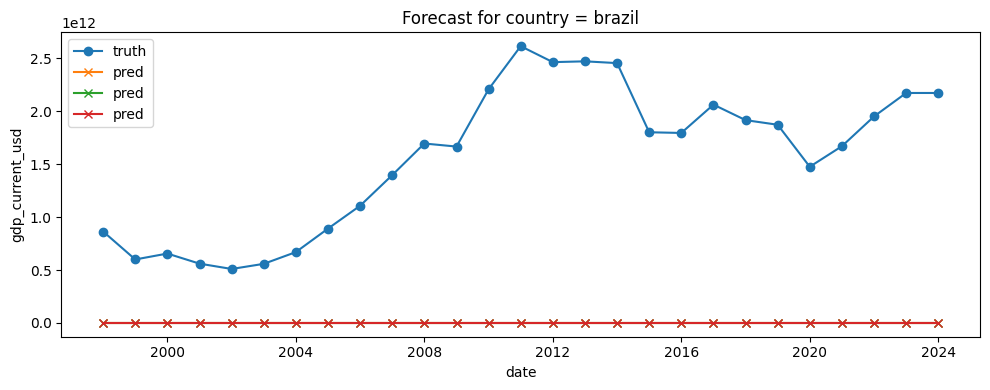

In [8]:


import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from src.logger import setup_logger, setup_logging
from src.preprocess.forecast_dataset import ForecastDataset, ForecastConfig

setup_logging()
logger = setup_logger(__name__)


# 2) build your ForecastConfig & dataset
all_cols = result_data.ml_ready.columns.tolist()
feat_cols = [c for c in all_cols if c not in ("date", "country", "gdp_current_usd")]


from src.preprocess.model_data import ForecastConfig
# 1) build your cfg exactly as when training
cfg = ForecastConfig(
  window_size=5, horizon=3,
  feat_cols=feat_cols,
  label_col="gdp_current_usd",
  group_col="country",
  date_col="date",
  val_frac=0.1, test_frac=0.1,
  batch_size=64,
  split_mode="temporal",
)


# 3) plot
plot_predictions_from_df(package, result_data.ml_ready, cfg, country="brazil")
# or
# plot_predictions_from_df(package.model, result_data.ml_ready, cfg, date="2024-12-31")
